# Healpy Introduction

#### This notebook briefly covers the basics of healpy and important functions used in my Master's Thesis.
#### Figures 3.4 and 3.6 correspond to the content presented here.
#### This material is a modification of the healpy tutorial, which is available at https://healpy.readthedocs.io/en/latest/index.html.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp

## Part 1 HealPix Pixelization Scheme

#### A Healpy map is represented as a NumPy array, with each pixel on the sky-map defined using the HealPix pixelization scheme.
#### The resolution of Healpy maps is controlled by a parameter known as $\text{NSIDE}$.

In [2]:
NSIDE=4096 # Standard resolution of cosmological analysis such as Planck
RES = hp.nside2resol(NSIDE, arcmin=True)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, RES/ 60
    )
)
NPIX = hp.nside2npix(NSIDE)
print("Number of pixels is", NPIX)

Approximate resolution at NSIDE 4096 is 0.014 deg
Number of pixels is 201326592


#### As you can see above, the sky is divided into $12 \times \text{NSIDE} \times \text{NSIDE}$ areas.
#### HealPix has two pixelization schemes: RING and NEST.

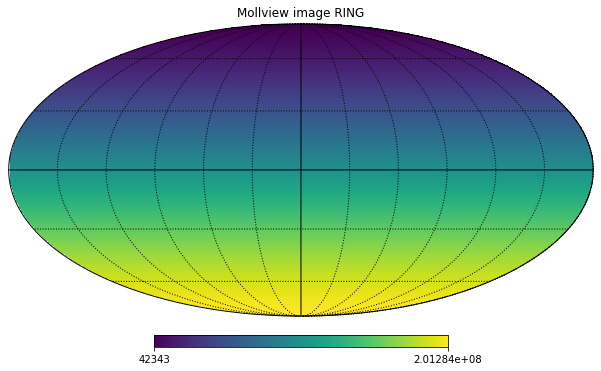

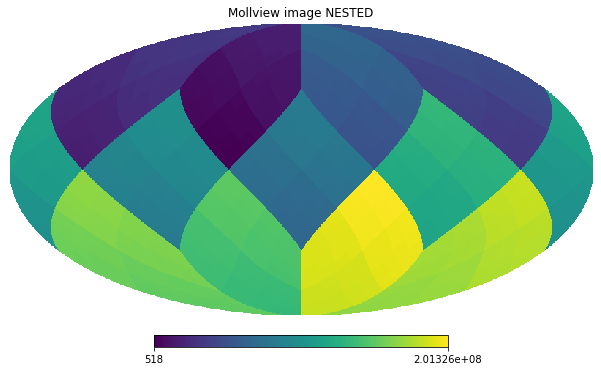

In [3]:
x = np.arange(NPIX)
hp.mollview(x,title='Mollview image RING')
hp.graticule()
hp.mollview(x, nest=True, title="Mollview image NESTED")

#### The RING format is well-suited for spherical harmonics transformation, while the NEST format is used for map domain operations.
#### Healpy internally performs calculations using the RING format.

## Part 2 Angular Powerspectrum

#### In CMB analysis and cosmic shear studies, the power spectrum in spherical harmonics is a fundamental tool for gaining insights into cosmology.
#### In this section, I will introduce Healpix functions for calculating the CMB temperature power spectrum using Planck data.
#### Reading and writing FITS files can be accomplished with Healpy as follows:

In [4]:
planck_map=hp.read_map("Data/COM_CMB_I-commander_2048_R3.00_full.fits")
hp.write_map("my_map.fits", planck_map, overwrite=True)

setting the output map dtype to [dtype('>f4')]


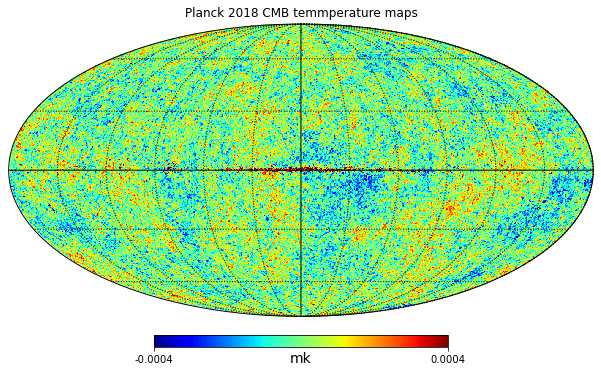

In [5]:
hp.mollview(planck_map,title='Planck 2018 CMB temmperature maps',cmap='jet',unit="mk",min=-0.0004,
    max=0.0004)
hp.graticule()

#### The temperature fluctuations of the CMB are associated with the density field at the time of recombination.
#### As you can see from the below, the density field in the early universe is Gaussian.
#### Non-Gaussian features can arise from secondary anisotropy, dust, exotic inflation, primordial gravitational effects, among others. However, we won't delve into these details in this context.
#### For more information, you can refer to https://arxiv.org/abs/1807.06209.

No handles with labels found to put in legend.


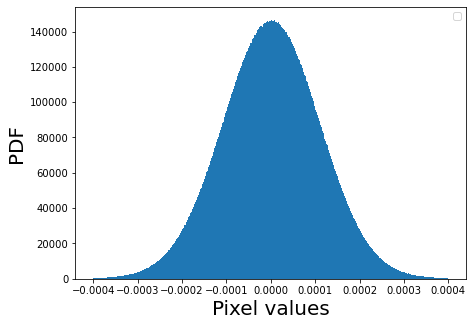

In [6]:
plt.figure(figsize=(7,5))
plt.hist(planck_map,bins=1000,range=[-0.0004,0.0004])
plt.xlabel("Pixel values", fontsize=20)
plt.ylabel("PDF", fontsize=20)
plt.legend(fontsize=10);
#plt.savefig("/home/r/R.Kanaki/Master_Arbeit_Final/CMB_fullsky_hist.jpg")

#### In the Galactic plane, there is dust emission.
#### Therefore, we would like to introduce a Photoshop technique known as the "mask" .

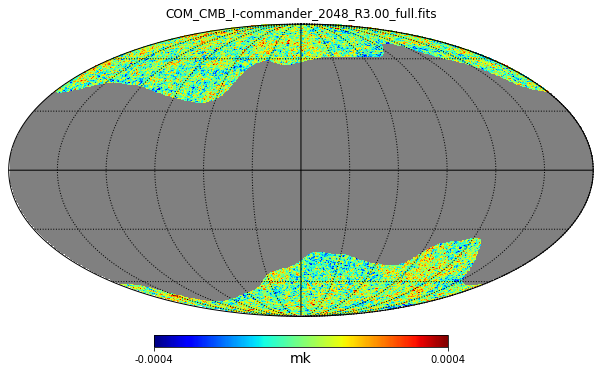

In [7]:
mask=hp.read_map("Data/HFI_Mask_GalPlane-apo0_2048_R2.00.fits")
planck_map_masked=hp.ma(planck_map)
planck_map_masked.mask=np.logical_not(mask)
hp.mollview(planck_map_masked,title='COM_CMB_I-commander_2048_R3.00_full.fits',cmap='jet',unit="mk",min=-0.0004,
    max=0.0004)
hp.graticule()
#plt.savefig("CMB.jpg")

#### After applying Photoshop, the observed sky area is sadly reduced... Therefore, we should account for the sky fraction when analyzing data.

In [8]:
sky_fraction = len(planck_map_masked.compressed()) / len(planck_map_masked)

#### HealPix provides a nice function known as "pixel weight" that, roughly speaking, represents the reliability of the data at a particular pixel.
#### Finally, we can compute the CMB power spectrum using the 'anafast' function.

In [9]:
lmax = 3000
ll = np.arange(lmax+1)
Cl = hp.anafast(planck_map_masked, lmax=lmax, use_pixel_weights=True)

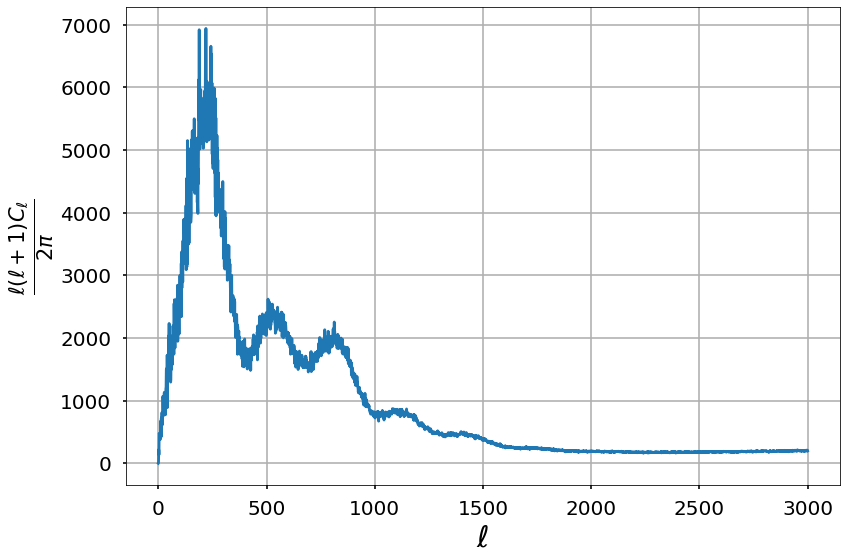

In [10]:
plt.style.use("seaborn-poster")
k2muK = 1e6
plt.plot(ll, ll*(ll+1.)*Cl*k2muK**2/2./np.pi / sky_fraction)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\ell$',fontsize=30)
plt.ylabel(r"$\frac{\ell(\ell+1)C_{\ell}}{2\pi}$",fontsize=30)
plt.grid()

#### Wow, geil, there are peaks!, unlike lensing! 
#### Is it similar to the plot in Dodelson Schmidt? If not, schade...

## Part 3. Downgrading
#### Unfortunately, we don't possess infinite computational power, so there are times when we must resort to downgrading.
#### Los in NVIDIA oder Google investieren; der gnädige Gott des Moore'schen Gesetzes wird bei der Seite von Kapitalisten lachen. Dieser Gott mag die Kohle...

#### N-body simulation is one of the best models for representing the density fluctuations in the late-time universe.
#### In this code, we are using the 弘前17 simulation (https://arxiv.org/abs/1706.01472).

In [11]:
Hirosaki_map_2048 = hp.read_map('Data/Hirosaki_maps.fits')

In [12]:
print(Hirosaki_map_2048)

[-0.00273944 -0.00501067 -0.0151408  ...  0.00624412  0.01623138
  0.00384923]


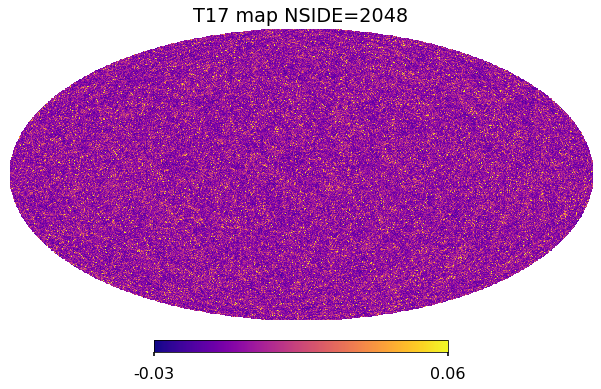

In [13]:
cmin = -0.03
cmax = 0.06
hp.mollview(Hirosaki_map_2048, nest=False,cmap='plasma',title='T17 map NSIDE=2048',min=cmin,max=cmax)

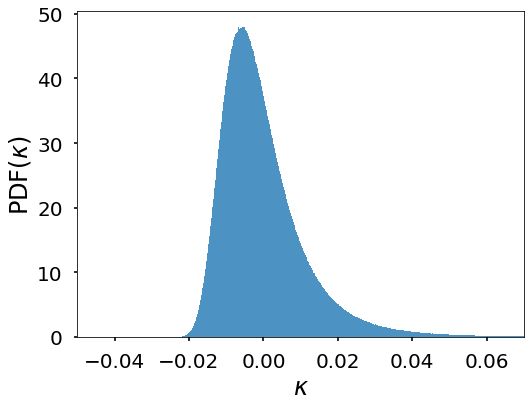

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(Hirosaki_map_2048, bins=10000,density=True,alpha=0.8)
plt.xlim(-0.05,0.07)
plt.ylabel(f'PDF($\kappa$)',fontsize=24)
plt.xlabel(f'$\kappa$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

#### As you can see above, unlike the case of CMB, the distribution of pixel values is slightly non-Gaussian.
#### The standard method '2pt Statistics' is insensitive to non-Gaussian information; therefore, in this thesis, we are conducting an analysis based on the field.
#### Now, we would like to observe the effect of downgrading.

In [15]:
Hirosaki_map_1024 = hp.ud_grade(Hirosaki_map_2048,nside_out=1024, order_in="RING", order_out="RING")
Hirosaki_map_512  = hp.ud_grade(Hirosaki_map_2048,nside_out=512, order_in="RING", order_out="RING")
Hirosaki_map_256  = hp.ud_grade(Hirosaki_map_2048,nside_out=256, order_in="RING", order_out="RING")
Hirosaki_map_128  = hp.ud_grade(Hirosaki_map_2048,nside_out=128, order_in="RING", order_out="RING")

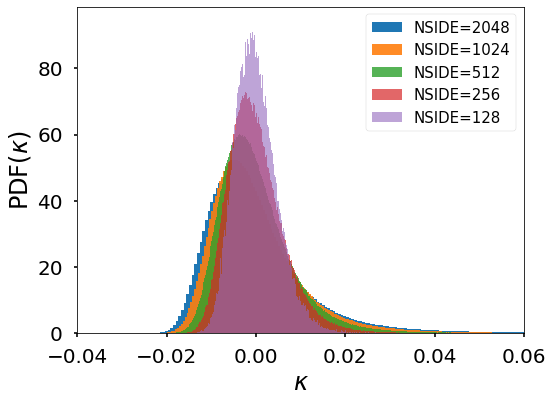

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(Hirosaki_map_2048, bins=1000,density=True,label='NSIDE=2048')
plt.hist(Hirosaki_map_1024, bins=1000,density=True,alpha=0.9,label='NSIDE=1024')
plt.hist(Hirosaki_map_512,  bins=1000,density=True,alpha=0.8,label='NSIDE=512')
plt.hist(Hirosaki_map_256,  bins=1000,density=True,alpha=0.7,label='NSIDE=256')
plt.hist(Hirosaki_map_128,  bins=1000,density=True,alpha=0.6,label='NSIDE=128')
plt.xlim(-0.04,0.06)
plt.legend(fontsize=15)
plt.ylabel(f'PDF($\kappa$)',fontsize=24)
plt.xlabel(f'$\kappa$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);